In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
import os
import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.random import sample_without_replacement
from simulations import q1, q2, noise, mse_calc
import itertools

In [2]:
data = pd.read_csv('cdc_NAL.csv')
data.head(10)

,Unnamed: 0,test_date,nid,gender,naics,age_group,region,NAICS_descr,500k,1k,...,8k,right_ear,H_3FA,IG_500k,IG_1k,IG_2k,IG_3k,IG_4k,IG_6k,IG_8k
0,0,12-FEB-2007,1,M,331512,4,MA,Steel Investment Foundries,20.0,20.0,...,45.0,1,16.666667,0.70,9.70,4.60,3.60,8.25,9.80,14.45
1,1,29-FEB-2008,2,M,331512,3,MA,Steel Investment Foundries,10.0,0.0,...,15.0,1,6.666667,-3.90,2.00,3.10,3.65,8.30,5.20,3.65
2,2,08-FEB-2006,3,M,331512,3,MA,Steel Investment Foundries,20.0,20.0,...,30.0,1,16.666667,0.70,9.70,4.60,5.15,12.90,9.80,9.80
3,3,29-FEB-2008,6,M,331512,4,MA,Steel Investment Foundries,10.0,10.0,...,20.0,1,8.333333,-3.65,5.35,1.80,8.55,10.10,7.00,5.45
4,4,08-FEB-2006,8,M,331512,3,MA,Steel Investment Foundries,15.0,15.0,...,5.0,1,11.666667,-1.60,7.40,2.30,12.15,15.25,5.95,1.30
5,5,29-FEB-2008,9,M,331512,3,MA,Steel Investment Foundries,5.0,0.0,...,20.0,1,3.333333,-5.95,1.50,1.05,0.05,0.05,0.05,4.70
6,6,29-FEB-2008,10,M,331512,2,MA,Steel Investment Foundries,10.0,5.0,...,0.0,1,6.666667,-3.90,3.55,1.55,0.55,0.55,0.55,-1.00
7,7,29-FEB-2008,11,M,331512,5,MA,Steel Investment Foundries,25.0,20.0,...,50.0,1,26.666667,3.75,11.20,13.85,22.15,22.15,23.70,17.50
8,8,29-FEB-2008,12,M,331512,3,MA,Steel Investment Foundries,10.0,15.0,...,20.0,1,10.000000,-3.40,7.15,2.05,7.25,11.90,2.60,5.70
9,9,08-FEB-2005,13,M,331512,5,MA,Steel Investment Foundries,10.0,10.0,...,20.0,1,10.000000,-3.40,5.60,3.60,2.60,5.70,1.05,5.70


In [3]:
np.random.seed(47)

In [4]:
#Create Type 1 simulations of actual audiograms. 
df = data[['500k', '1k', '2k', '3k', '4k', '6k', '8k']].sample(30000, random_state=47).reset_index().drop(columns=['index'])

X = []

for i in range(len(df)):
    
    ls = []
    for j in df:
        
        example_data = df.loc[i]
        test_volumes = np.array([0.2*i for i in range(10)]) * np.mean(df[j])
        ls.append(q1(data=example_data, freq=j, volumes=test_volumes, noise_max=3, noise_min=0, noise_type='normal'))
    X.append(ls)
    
X = pd.DataFrame(X, columns=['500k', '1k', '2k', '3k', '4k', '6k', '8k'])
    

In [5]:
#Actual audiograms to predict. 
Y = data[['500k', '1k', '2k', '3k', '4k', '6k', '8k']].sample(30000, random_state=47).reset_index().drop(columns=['index'])

#Separate list of xgboost models. Will use to plot feature importance and tree. 
data_m_list = [xgb.DMatrix(data=X, label=Y[n]) for n in ['500k', '1k', '2k', '3k', '4k', '6k', '8k']] 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=47)

In [7]:
#Must use multi-output regressor in order to predict all frequencies. Assumes independence between each feature. 
model = MultiOutputRegressor(XGBRegressor(max_depth=5))

In [8]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                         

In [9]:
y_fitted = model.predict(X_train)
y_preds = model.predict(X_test)

print('RSquared:% f' % r2_score(y_test, y_preds))

RSquared: 0.857911


In [10]:
rmse_1 = np.sqrt(mean_squared_error(y_test, y_preds))
rmse_2 = np.sqrt(mean_squared_error(y_train, y_fitted))
print("Train RMSE: %f" % (rmse_2))
print("Test RMSE: %f" % (rmse_1))

Train RMSE: 4.790530
Test RMSE: 5.069066


In [11]:
importances = []
for i in model.estimators_:
    
    importances.append(i.feature_importances_)
      
importances = pd.DataFrame(importances, columns=['500k', '1k', '2k', '3k', '4k', '6k', '8k'])
importances


,500k,1k,2k,3k,4k,6k,8k
0,0.927683,0.038033,0.011498,0.014479,0.001660,0.003103,0.003544
1,0.029494,0.904805,0.021637,0.033653,0.004020,0.001800,0.004590
2,0.004236,0.021653,0.829559,0.096679,0.025059,0.012736,0.010079
3,0.002564,0.002506,0.011898,0.903031,0.055007,0.022057,0.002936
4,0.002642,0.001956,0.003053,0.021900,0.910244,0.054034,0.006170
5,0.002210,0.002380,0.002942,0.007698,0.024240,0.920662,0.039868
6,0.002552,0.002638,0.004055,0.013572,0.006728,0.062126,0.908330


In [14]:
#Params used to train separate xgboost models. These are only for visualizations. 
params = {'colsample_bytree': 1,'learning_rate': 0.3,
                'max_depth': 3, 'alpha': 0}

In [15]:
xgb.cv(dtrain=data_m_list[0], params=params, nfold=3, 
                    num_boost_round=15,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=47)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.237650,0.006701,8.237207,0.022739
1,6.106311,0.007779,6.106501,0.027392
2,4.717241,0.010408,4.717543,0.030467
3,3.853440,0.013581,3.855365,0.035751
4,3.347056,0.015885,3.349356,0.038206
5,3.065628,0.017973,3.068275,0.038815
6,2.915811,0.019452,2.919542,0.039560
7,2.838918,0.020213,2.842975,0.039832
8,2.799040,0.020856,2.803362,0.039822
9,2.778593,0.020746,2.783318,0.040003


In [16]:
#One xgboost model for 500k frequency. Only used for visualizations below. 
model = xgb.train(params=params, dtrain=data_m_list[0], num_boost_round=10)

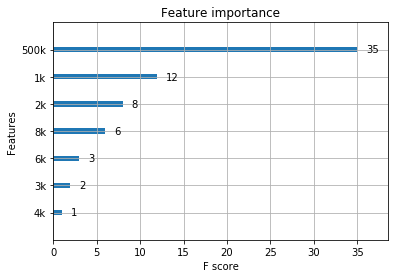

In [17]:
#Feature importance for xgboost model predicting 500k. 
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [19]:
#Actual xgboost tree showing splitting points. 
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [800, 100]
plt.show()